In [1]:
%load_ext autoreload
%autoreload 2

from dataset import TokenTypesDataset
import torch

In [2]:
train_dataset = TokenTypesDataset(folder="../rnn_tokentype_data/train")
val_dataset = TokenTypesDataset(folder="../rnn_tokentype_data/validation", train=False, vocabs=(train_dataset.token2idx, train_dataset.idx2token), max_length=train_dataset.max_length)
test_dataset = TokenTypesDataset(folder="../rnn_tokentype_data/test", train=False, vocabs=(train_dataset.token2idx, train_dataset.idx2token), max_length=train_dataset.max_length)
assert val_dataset.vocab_size == train_dataset.vocab_size == test_dataset.vocab_size
assert val_dataset.max_length == train_dataset.max_length == test_dataset.max_length

In [3]:
train_dataset.max_length

512

In [4]:
from model import LanguageModel
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = LanguageModel(train_dataset).to(device)

In [5]:
for bs in [1, 4]:
    indices = torch.randint(high=train_dataset.vocab_size, size=(bs, train_dataset.max_length))
    lengths = torch.randint(low=1, high=train_dataset.max_length + 1, size=(bs, ))
    logits = model(indices, lengths)
    assert logits.shape == (bs, lengths.max(), train_dataset.vocab_size)

In [6]:
train_dataset.max_length

512

In [7]:
import torch.nn as nn
from torch.utils.data import DataLoader
from train import train

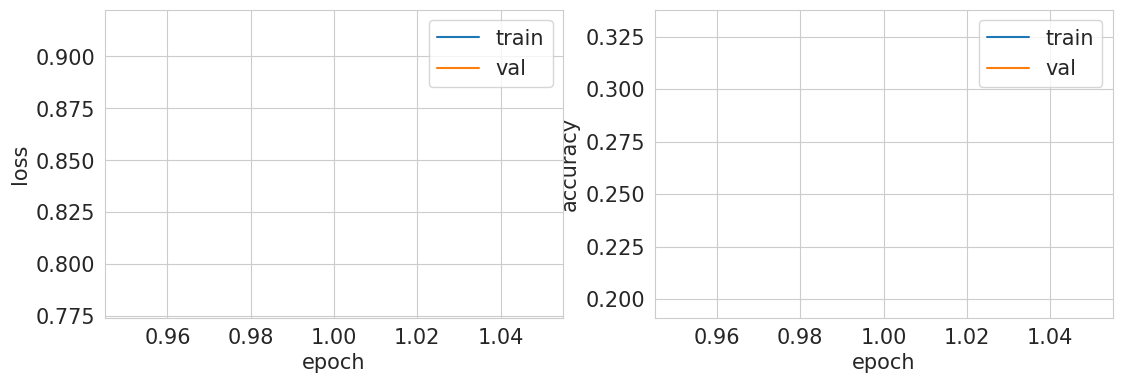

Training 2/30:   0%|          | 0/467 [00:00<?, ?it/s]

In [16]:
NUM_EPOCHS = 30

torch.manual_seed(42)

model = LanguageModel(train_dataset, rnn_type=nn.LSTM).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = None
criterion = nn.CrossEntropyLoss(ignore_index=train_dataset.pad_id)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=8, pin_memory=True)
test_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=8, pin_memory=True)

train(model, optimizer, scheduler, train_loader, test_loader,  NUM_EPOCHS)

torch.save(model.state_dict(), "vanilla_rnn.pth")

In [13]:
from tqdm.notebook import tqdm

In [14]:
def evaluate(path_to_file: str, model) -> float:
    cnt = 0
    hit_cnt = 0
    with open(path_to_file, "r") as file:
        for line in tqdm(file):
            tokens = line.split()
            for i in range(1, len(tokens) + 1):
                predicted = model.inference(tokens[:i])
                real_token = ""
                if i == len(tokens):
                    real_token = "<EOS>"
                else:
                    real_token = tokens[i]
                if predicted == real_token:
                    hit_cnt += 1
                #print(f"REAL: {real_token}, PREDICTED: {predicted}")
            cnt += (len(tokens) - 1)
    return(hit_cnt / cnt)

In [32]:
model.inference(["KeyWord", "Semicolon"])

'Identifier'

In [15]:
evaluate(path_to_file="../rnn_tokentype_data/test/wikisql_test.txt", model=model)

0it [00:00, ?it/s]

0.6668943479603716